In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Swarm plotting class and function
class Swarm:
    LEFT = 0
    RIGHT = 1
#     RADIUS = 0.7

    def __init__(self, yList, panel, center, width, xmin, xmax, ymin, ymax, panelWidth, panelHeight, pointsize):
        self.yList = yList
        self.panel = panel
        self.center = center
        self.width = width
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.panelWidth = panelWidth
        self.panelHeight = panelHeight
        self.pointsize = pointsize
        self.RADIUS = pointsize/72 #/ 2 # I think maybe?
        self.plottedPoints = []

    def xpaperCoord(self, x1, x2):
        return np.abs(x2-x1) * self.panelWidth / (self.xmax - self.xmin)

    def ypaperCoord(self, y1, y2):
        return np.abs(y2-y1) * self.panelHeight / (self.ymax - self.ymin)

    def dist(self, x1, y1, x2, y2):
        xdist = self.xpaperCoord(x1, x2)
        ydist = self.ypaperCoord(y1, y2)
        return ( (xdist)**2 + (ydist)**2 )**0.5

    def getXCandidates(self, x1, y1, x2, y2):
        ''' 
        Given coords of 2 points and a radius for both points
        returns x value(s) for the 2nd point so that the points touch without overlapping 
        '''
        if (self.dist(x1, y1, x2, y2) <= 2*self.RADIUS):
            ydist = self.ypaperCoord(y1, y2)
            rightx = ( 4*(self.RADIUS**2) - (ydist)**2 )**0.5 * (self.xmax - self.xmin)/self.panelWidth + x1
            leftx = -1 * ( 4*(self.RADIUS**2) - (ydist)**2 )**0.5 * (self.xmax - self.xmin)/self.panelWidth + x1
            return (leftx, rightx)
        else: # Return point 2's current x if there is no overlap
            return (x2, x2)

    def closest(self, center, x1, x2):
        '''
        Given a center value and 2 other values x1, x2
        Return the value closest to the center
        '''
        if np.abs(x1 - center) < np.abs(x2 - center):
            return x1
        else:
            return x2

    def overlap(self, x1, y1, x2, y2):
        if (self.dist(x1, y1, x2, y2) < 2*self.RADIUS):
            return True
        else:
            return False

    def plot(self, xpos, ypos):
        self.panel.plot(xpos, ypos,
                        marker='o', 
                        markersize=self.pointsize,
                        linewidth=0,
                        markeredgewidth=0,
                        markerfacecolor = 'black',
                        )
        self.plottedPoints.append( (xpos, ypos) )

    def getSafePoint(self, ypos, xpos, side):
        # check plotted points for overlap
        isOverlapping = True
        while(isOverlapping):
            for pointx, pointy in self.plottedPoints:
                isOverlapping = False
                if (self.overlap(pointx, pointy, xpos, ypos)):
                    isOverlapping = True
                    xCandidates = self.getXCandidates(pointx, pointy, xpos, ypos)
                    xpos = xCandidates[side]
                    if (side == self.LEFT):
                        xpos -= 0.00001
                    else:
                        xpos += 0.00001
                    break
        return xpos

    def plotQuantiles(self):
        for q in [0.25, 0.5, 0.75]:
            if q != 0.5:
                color = 'black'
            else:
                color = 'red'
            quantile = np.quantile(self.yList, q)
            self.panel.plot([self.center-self.width/2, self.center+self.width/2],
                        [quantile,quantile],
                        linewidth=1,
                        color=color,
                        zorder=10)
    
    def createSwarmPlot(self):
        extrapoints = 0
        for index, ypos in enumerate(self.yList):
            xpos = xposLeft = xposRight = self.center
            if (index == 0):
                self.plot(xpos, ypos)
                continue

            # check plotted points for overlap
            xposLeft = self.getSafePoint(ypos, xpos, side=self.LEFT)
            xposRight = self.getSafePoint(ypos, xpos, side=self.RIGHT)
            xpos = self.closest(self.center, xposLeft, xposRight)
            if (xpos > (self.center + self.width/2) or xpos < (self.center - self.width/2)):
                extrapoints = len(self.yList) - len(self.plottedPoints)
                break
            self.plot(xpos, ypos)
        self.plotQuantiles()
        return extrapoints


def swarm(yList, panel, center, width, xmin, xmax, ymin, ymax, panelWidth, panelHeight, pointsize):
    '''
    Creates a swarm plot
    Returns number of points not plotted once it reaches the width limit
    '''
    swarmPlot = Swarm(yList, panel, center, width, xmin, xmax, ymin, ymax, panelWidth, panelHeight, pointsize)
    return swarmPlot.createSwarmPlot()


5557 points not plotted on list 3


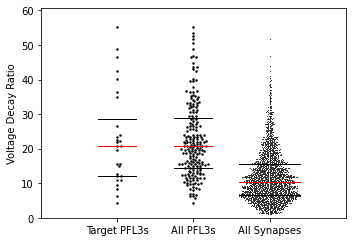

In [9]:
figureWidth = 8.5
figureHeight = 11
panelWidth = 6
panelHeight = 8

panel = plt.axes([0.1, 0.1, panelWidth/figureWidth, panelHeight/figureHeight])

csvfile = r'..\data\DNa02-1140245595_typed_simulation_data.csv'
df = pd.read_csv(csvfile)

df['voltdr'] = df['in_voltage'] / df['out_voltage']

targetPFL3 = df[df['instance'] == 'PFL3(PB12c)_R2_C1_irreg']
allPFL3 = df[df['type'] == 'PFL3']

xmin=0
xmax=20
ymin=0
ymax=max(df['voltdr'])*1.2


for index, data in enumerate([targetPFL3, allPFL3, df]):
    if index == 2:
        width = 4
        pointsize=1
    else:
        width =2.5
        pointsize=2.5
    yList = list(data['voltdr'])
    np.random.shuffle(yList)
    extrapoints = swarm(yList, panel,
                          center=5*(index+1), width=width,
                          xmin=xmin, xmax=xmax,
                          ymin=ymin, ymax=ymax,
                          panelWidth=panelWidth,
                          panelHeight=panelHeight,
                          pointsize=pointsize)
    if extrapoints > 0:
        print(f"{extrapoints} points not plotted on list {index+1}")


panel.set_xlim([xmin, xmax])
panel.set_ylim([ymin, ymax])
panel.set_xticks([5, 10, 15])
panel.set_xticklabels(['PFL3 of Interest', 'All PFL3s', 'All Synapses'])

panel.set_ylabel('Voltage Decay Ratio')

panel.tick_params(bottom=True, labelbottom=True,
                      left=True, labelleft=True,
                      right=False, labelright=False,
                      top=False, labeltop=False,)

outfile = 'voltageDecayRatioSwarmPlot.png'
plt.savefig(outfile, dpi=600)